# Combining satellite data with tidal modelling using OTPS

* **Products used:** 
[ls5_sr](https://explorer.digitalearth.africa/ls5_sr),
[ls7_sr](https://explorer.digitalearth.africa/ls7_sr), 
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr)

## Background

Ocean tides are the periodic rise and fall of the ocean caused by the gravitational pull of the moon and sun and the earth's rotation. 
Tides in coastal areas can greatly influence how these environments appear in satellite imagery as water levels vary by up to 12 metres.
To be able to study environmental processes along Africa's coastline, it is vital to obtain data on tidal conditions at the exact moment each satellite image was acquired.

## Description
This notebook demonstrates how to combine remotely sensed imagery with information about ocean tides using functions from the [eo-tides Python package](https://geoscienceaustralia.github.io/eo-tides/), allowing us to analyse satellite imagery by tide heights and tidal stage (e.g. low, high, ebb, flow). These functions use the global ocean tide models to calculate the height (relative to mean sea level) and stage of the tide at the exact moment each satellite image was acquired.

The notebook demonstrates how to:

1. Load an example time series of satellite data
2. Use the `tag_tide` function from `eo-tides package` to model tide heights for each satellite observation
3. Use tide height data to produce median composites of the coast at low and high tide
4. Compute ebb or flow tide phase data to determine whether water levels were rising or falling in each satellite observation
5. Use the `tidal_stats` function to evaluate any biases in the tidal conditions observed by a satellite

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.geom import Geometry

from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from eo_tides import tag_tides
from eo_tides.stats import tide_stats
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.areaofinterest import define_area

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel.
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 11.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38337,Workers: 1
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 11.21 GiB
Comm: tcp://127.0.0.1:36451,Total threads: 2
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/40739/status,Memory: 11.21 GiB
Nanny: tcp://127.0.0.1:43513,


### Connect to the datacube


In [3]:
dc = datacube.Datacube(app='Tidal_modelling')

### Set up data query

First we set up a query to define the area, time period and other parameters required for loading data.
In this example, we will load 30 years of Landsat 5, 7 and 8 data for the Geba River Estuary in southern Guinea-Bissau.
We load the `'red', 'green', 'blue'` bands so that we can plot the data as true colour imagery.

> **Note**: The `dask_chunks` parameter allows us to [use Dask to lazily load data rather than load data directly into memory](https://examples.dask.org/xarray.html), as the standard loading method can take a long time and large amounts of memory.
Lazy loading can be a very useful approach for when you need to load large amounts of data without crashing your analysis.
In coastal applications, it allows us to load (using either `.compute()` or by plotting our data) only a small subset of observations from our entire time series (e.g. only low or high tide observations) without having to load the entire dataset into memory first, which can greatly decrease processing times.

#### Define location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [4]:
# Define the location
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=11.689, lon=-15.674, buffer=0.15)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# Create a reusable query
query = {
    'x': lon_range,
    'y': lat_range,
    'time': ('1988-01-01', '2018-12-31'),
    'measurements': ['red', 'green', 'blue'],
    'resolution': (-30, 30), 
    'dask_chunks': {}
}

We can preview the area that we will load data for:

In [5]:
display_map(x=query['x'], y=query['y'])


## Load satellite time-series

To obtain some satellite data to analyse, we use the `load_ard` function to import a time series of Landsat 5, 7 and 8 observations as an `xarray.Dataset`.
The input data does not need to be from Landsat: any remotely-sensed imagery with timestamps and spatial coordinates provide enough data to run the tidal model. 

In [6]:
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_sr', query=query)

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc, 
              products=['ls5_sr', 'ls7_sr', 'ls8_sr'],
              output_crs=output_crs,
              align=(15, 15),
              ls7_slc_off=False,
              group_by='solar_day',
              **query)

# Print output data
print(ds)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    Ignoring SLC-off observations for ls7
    ls8_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 227 time steps as a dask array
<xarray.Dataset> Size: 3GB
Dimensions:      (time: 227, y: 1109, x: 1093)
Coordinates:
  * time         (time) datetime64[ns] 2kB 1988-07-17T10:52:47.658038 ... 201...
  * y            (y) float64 9kB 1.309e+06 1.309e+06 ... 1.276e+06 1.276e+06
  * x            (x) float64 9kB 4.102e+05 4.102e+05 ... 4.429e+05 4.429e+05
    spatial_ref  int32 4B 32628
Data variables:
    red          (time, y, x) float32 1GB dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    green        (time, y, x) float32 1GB dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    blue         (time, y, x) float32 1GB dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


/opt/venv/lib/python3.12/site-packages/deafrica_tools/datahandling.py:565: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds_data, ds_masks])


## Model tide heights for each observation

We can now pass our satellite dataset `ds` to the `tag_tides` function to model a tide for each timestep in our dataset.

The `tag_tides` function uses the time and date of acquisition and the geographic centroid of each satellite observation as inputs for the selected tide model (EOT20 by default). It returns an `xarray.DataArray` called `tide_height`, with a modelled tide for every timestep in our satellite dataset:

In [7]:
# # Model tide heights
model_dir = "/var/share/tide_models"

tides_da = tag_tides(
    data=ds,
    directory=model_dir,
)

# Print modelled tides
tides_da

Setting tide modelling location from dataset centroid: -15.67, 11.69
Modelling tides with EOT20


<xarray.DataArray 'tide_height' (time: 227)> Size: 908B
array([ 0.8592769 , -0.18536592, -0.24930622, -0.21912642,  1.3536943 ,
        1.5856296 , -0.36671248, -1.162862  , -0.84991807,  0.78121537,
        1.2990576 ,  0.5875723 , -0.5906921 , -1.198272  , -0.87473166,
       -0.23873524, -0.46583444,  0.8389599 ,  1.2147173 , -0.90109295,
        2.2094488 , -0.10366018, -0.7232631 ,  0.93119794,  0.09051751,
       -1.5260075 ,  0.4858677 , -1.0699933 , -0.9408271 , -0.7329113 ,
        2.3638723 ,  1.5525019 ,  0.1859477 , -1.1284522 ,  0.02373447,
        1.9752105 ,  1.4451119 ,  0.08928777, -1.1222141 , -0.9019982 ,
       -1.0450093 ,  0.79601216,  2.3718722 ,  1.4501921 , -0.06832927,
       -1.0044726 , -1.0839821 ,  0.17514926,  1.235538  ,  1.4246706 ,
        0.99165756, -1.0692114 , -0.80042666,  0.8843542 ,  1.5233799 ,
        2.4851034 ,  0.8361768 , -0.30938658, -1.2930602 , -1.010503  ,
       -0.8662913 ,  1.3671592 ,  1.7509861 , -0.29216802, -0.8316837 ,
        0.6845504 ,  0.9089041 ,  1.5951457 ,  2.4264863 ,  1.636322  ,
        1.1844784 ,  0.6951644 , -0.5465059 , -1.1753923 , -1.0261688 ,
       -1.1895244 , -0.65899706,  0.6656056 ,  1.5154617 ,  1.7234896 ,
        1.0035887 , -0.26266134, -0.8812882 , -1.418292  , -0.77705395,
        0.09498855,  0.34845093,  1.3668454 ,  2.103673  ,  1.6849209 ,
        1.6869351 , -0.23761284, -0.5975377 , -0.8819262 , -1.2235104 ,
       -0.49499667,  0.59162694, -0.21275352,  0.59459233,  1.6347721 ,
...
       -0.9089948 , -0.27688542, -0.162714  ,  1.245498  ,  1.928993  ,
        1.8759419 ,  2.3370724 ,  1.5809414 ,  0.30614835, -0.11390533,
       -0.92469454, -1.5192188 , -0.9430964 , -0.40575445, -0.19064783,
        1.0995171 ,  1.6986959 ,  1.7050391 ,  2.1494768 ,  1.3949219 ,
        0.20653185, -0.14812092, -1.0164082 , -1.4779083 , -0.7888232 ,
       -0.31432354,  1.4256083 ,  1.9217592 ,  2.3725417 ,  1.3677355 ,
        0.12567818, -0.16532955, -1.123294  , -1.5323508 , -0.8538998 ,
       -0.4728178 ,  0.01170299,  1.2474009 ,  1.7048676 ,  1.7812264 ,
        2.1977248 ,  1.234935  ,  0.09342687, -0.1761156 , -1.1653123 ,
       -1.4053906 , -0.6627003 ,  0.30462867,  1.5867989 ,  1.9666264 ,
        2.3179724 ,  1.1569254 , -0.02334541, -0.24811259, -1.2985601 ,
       -1.4740304 , -0.7577282 , -0.5203916 ,  0.24021955,  1.3851444 ,
        1.6893141 ,  1.8696413 ,  2.1551821 ,  1.0754136 ,  0.01313501,
       -0.23448984, -1.2910479 , -1.2690802 , -0.53377897,  0.5520059 ,
        1.7250115 ,  1.8446099 ,  2.008283  ,  2.1571045 ,  0.95168877,
       -0.13945593, -0.35539186, -1.4434679 , -1.3494217 , -0.66648966,
       -0.5192263 ,  0.45858455,  1.50598   ,  1.6530383 ,  1.971703  ,
        2.0207052 ,  0.925047  , -1.3809084 , -1.0875833 , -0.41610128,
        0.7656607 ,  1.8128856 ,  1.733615  ,  2.0340157 ,  1.9105709 ,
        0.7570475 , -0.20097291], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2kB 1988-07-17T10:52:47.658038 ... 2018...
    tide_model  <U5 20B 'EOT20'

We can easily combine these modelled tides with our original satellite data for further analysis. The code below adds our modelled tides as a new `tide_height` variable under **Data variables**.

In [8]:
ds["tide_height"] = tides_da
ds

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 227, y: 1109, x: 1093)
Coordinates:
  * time         (time) datetime64[ns] 2kB 1988-07-17T10:52:47.658038 ... 201...
  * y            (y) float64 9kB 1.309e+06 1.309e+06 ... 1.276e+06 1.276e+06
  * x            (x) float64 9kB 4.102e+05 4.102e+05 ... 4.429e+05 4.429e+05
    spatial_ref  int32 4B 32628
    tide_model   <U5 20B 'EOT20'
Data variables:
    red          (time, y, x) float32 1GB dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    green        (time, y, x) float32 1GB dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    blue         (time, y, x) float32 1GB dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    tide_height  (time) float32 908B 0.8593 -0.1854 -0.2493 ... 0.757 -0.201
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

We can easily plot this new variable to inspect the range of tide heights observed by the satellites in our timeseries.
In this example, our observed tide heights range from approximately -1.0 to 1.0 m relative to Mean Sea Level:

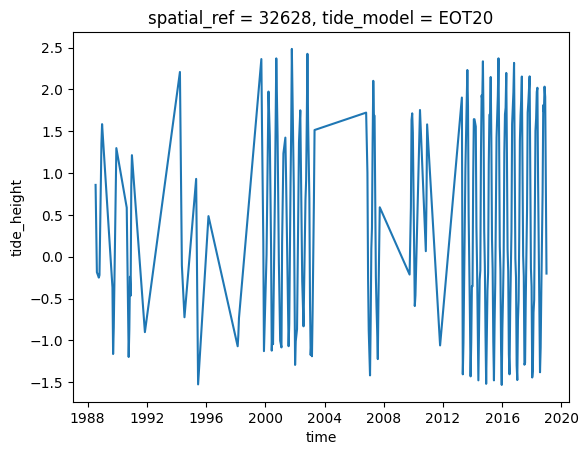

In [9]:
ds.tide_height.plot()

### Example tide height analysis
To demonstrate how tidally tagged images can be used to produce composites of high and low tide 
imagery, we can compute the lowest 5% and highest 5% percent of tide heights, and use these to filter our observations. 
We can then combine and plot these filtered observations to visualise what the landscape looks like at low and high tide:

> **Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

> **Note**: An alternative approach to combining observations into a composite can be achieved using a geomedian, which ensures band relationships are kept consistent. 
More information is provided in the [Generating geomedian composites notebook](Generating_geomedian_composites.ipynb).

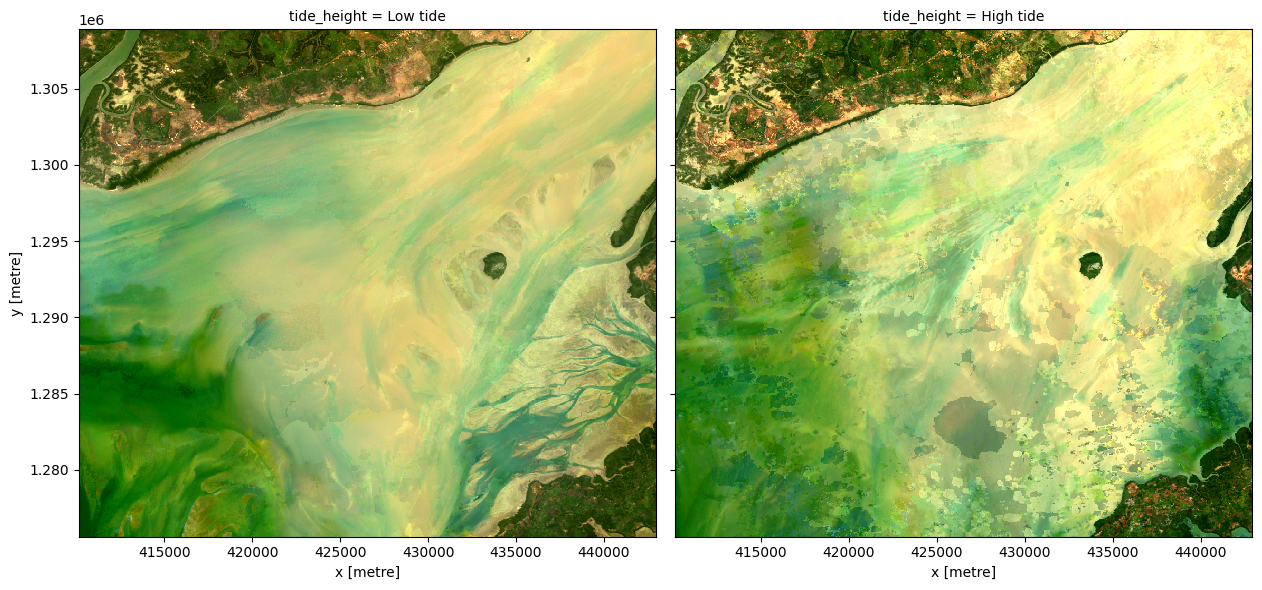

In [10]:
# Calculate the lowest and highest 5% of tides
lowest_5, highest_5 = ds.tide_height.quantile([0.05, 0.95]).values

# Filter our data to low and high tide observations
filtered_low = ds.where(ds.tide_height <= lowest_5, drop=True)
filtered_high = ds.where(ds.tide_height >= highest_5, drop=True)

# Take the simple median of each set of low and high tide observations to 
# produce a composite (alternatively, observations could be combined 
# using a geomedian to keep band relationships consistent)
median_low = filtered_low.median(dim='time', keep_attrs=True)
median_high = filtered_high.median(dim='time', keep_attrs=True)

# Combine low and high tide medians into a single dataset and give 
# each layer a meaningful name
ds_highlow = xr.concat([median_low, median_high], dim='tide_height')
ds_highlow['tide_height'] = ['Low tide', 'High tide']

# Plot low and high tide medians side-by-side
rgb(ds_highlow, col='tide_height')


## Modelling ebb and flow tidal phases

The `tag_tides` function also allows us to determine whether each satellite observation was taken while the tide was rising/incoming (flow tide) or falling/outgoing (ebb tide) by setting `return_phases=True`. This is achieved by comparing tide heights 15 minutes before and after the observed satellite observation.

Ebb and flow data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

In [11]:
tides_da = tag_tides(
    data=ds,
    directory=model_dir,
    return_phases=True,
)

# Print modelled tides
tides_da

Setting tide modelling location from dataset centroid: -15.67, 11.69
Modelling tides with EOT20
Modelling tides with EOT20


<xarray.Dataset> Size: 5kB
Dimensions:      (time: 227)
Coordinates:
  * time         (time) datetime64[ns] 2kB 1988-07-17T10:52:47.658038 ... 201...
    tide_model   <U5 20B 'EOT20'
Data variables:
    tide_height  (time) float32 908B 0.8593 -0.1854 -0.2493 ... 0.757 -0.201
    tide_phase   (time) object 2kB 'high-flow' 'low-flow' ... 'low-flow'

We now have data giving us the both the tide height and tidal phase ('ebb' or 'flow') for every satellite image:

In [12]:
tides_da[["time", "tide_height", "tide_phase"]].to_dataframe()

,tide_height,tide_phase,tide_model
time,,,
1988-07-17 10:52:47.658038,0.859277,high-flow,EOT20
1988-08-18 10:52:49.179013,-0.185366,low-flow,EOT20
1988-10-05 10:52:43.680006,-0.249306,low-ebb,EOT20
1988-10-21 10:52:37.662000,-0.219126,low-ebb,EOT20
1988-12-08 10:52:31.815006,1.353694,high-ebb,EOT20
...,...,...,...
2018-10-24 11:21:58.388427,1.733615,high-ebb,EOT20
2018-11-09 11:22:01.151598,2.034016,high-flow,EOT20
2018-11-25 11:22:00.936674,1.910571,high-flow,EOT20


We could for example use this data to filter our observations to keep ebbing phase observations only:

In [13]:
tides_da.where(tides_da.tide_phase.str.contains('ebb'), drop=True)

<xarray.Dataset> Size: 2kB
Dimensions:      (time: 108)
Coordinates:
  * time         (time) datetime64[ns] 864B 1988-10-05T10:52:43.680006 ... 20...
    tide_model   <U5 20B 'EOT20'
Data variables:
    tide_height  (time) float32 432B -0.2493 -0.2191 1.354 ... 1.813 1.734
    tide_phase   (time) object 864B 'low-ebb' 'low-ebb' ... 'high-ebb'

## Evaluating observed vs. all modelled tide heights

The complex behaviour of tides mean that a sun synchronous sensor like Landsat [does not observe the full range of the tidal cycle at all locations](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3).
Biases in the proportion of the tidal range observed by satellites can prevent us from obtaining data on areas of the coastline exposed or inundated at the extremes of the
tidal range. 
This can risk gaining misleading insights into the true extent of the area of the coastline affected by tides, and make it difficult to compare high or low tide images fairly in different locations.

The `tide_stats` function can assist in evaluating how the range of tides observed by satellites compare to the full tidal range.
It works by using the OTPS tidal model to model tide heights at a regular interval (every two hours by default) across the entire time period covered by the input satelliter timeseries dataset.
This is then compared against the tide heights in observed by the satellite and used to calculate a range of statistics and a plot that summarises potential biases in the data.

> **Note**: For a more detailed discussion of the issue of tidal bias in sun-synchronous satellite observations of the coastline, refer to the ['Limitations and future work' section in Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3).


Using tide modelling location: -15.67, 11.69
Modelling tides with EOT20
Using tide modelling location: -15.67, 11.69
Modelling tides with EOT20


🌊 Modelled astronomical tide range: 5.13 m (-2.53 to 2.60 m).
🛰️ Observed tide range: 4.02 m (-1.53 to 2.49 m).

🟡 78% of the modelled astronomical tide range was observed at this location.
🟢 The highest 2% (0.12 m) of the tide range was never observed.
🟡 The lowest 19% (1.00 m) of the tide range was never observed.

🌊 Mean modelled astronomical tide height: 0.00 m.
🛰️ Mean observed tide height: 0.34 m.
⬆️ The mean observed tide height was 0.34 m higher than the mean modelled astronomical tide height.


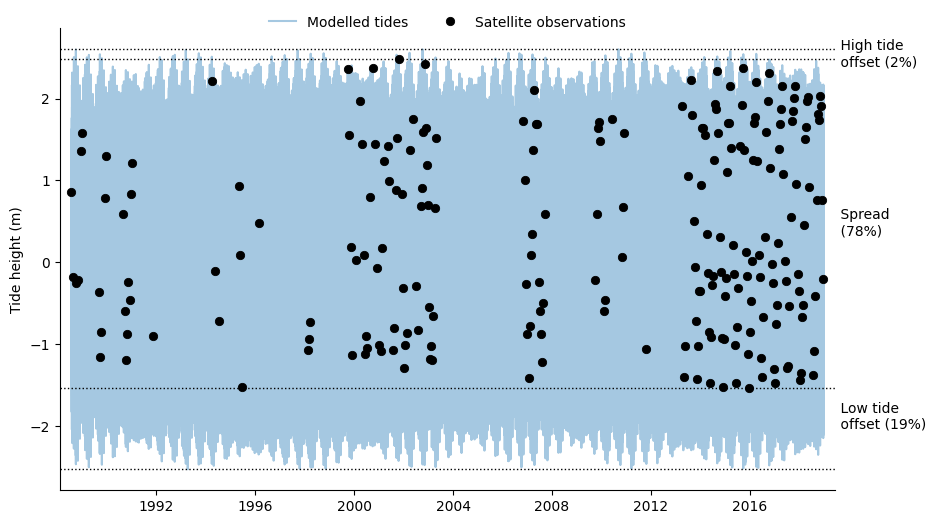

In [14]:
out_stats = tide_stats(data=ds,directory=model_dir)

The `tide_stats` function also outputs a `pandas.Series` object containing a set of statistics that compare the observed vs. full modelled tidal ranges.
These statistics include:

- **mot**: mean tide height observed by the satellite (metres)
- **mat**: mean modelled astronomical tide height (metres)
- **hot**: maximum tide height observed by the satellite (metres)
- **hat**: maximum tide height from modelled astronomical tidal range (metres)
- **lot**: minimum tide height observed by the satellite (metres)
- **lat**: minimum tide height from modelled astronomical tidal range (metres)
- **otr**: tidal range observed by the satellite (metres)
- **tr**: modelled astronomical tide range (metres)
- **spread**: proportion of the full modelled tidal range observed by the satellite
- **offset_low**: proportion of the lowest tides never observed by the satellite
- **offset_high**: proportion of the highest tides never observed by the satellite
- **y**: latitude used for modelling tide heights
- **x**: longitude used for modelling tide heights


In [15]:
print(out_stats)

mot             0.344
mat             0.000
hot             2.485
hat             2.603
lot            -1.532
lat            -2.529
otr             4.017
tr              5.131
spread          0.783
offset_low      0.194
offset_high     0.023
x             -15.674
y              11.689
dtype: float32


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-12-02'